# Sheet 4
## 3 K-Nearest Neighbors: Cross-Validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt

load the data

In [2]:
# for faster runtimes, we use a subsampled version of the data even as the 'full' dataset
full_features = np.load('data/dijet_features_normalized.npy')[:, ::2]
full_labels = np.load('data/dijet_labels.npy')[::2]

dset_full = (full_features, full_labels) 
dset_medium = (full_features[:, ::4], full_labels[::4])
dset_small = (full_features[:, ::16], full_labels[::16])
dsets = (dset_small, dset_medium, dset_full)

for features, labels in dsets:
    print(features.shape, labels.shape)

(116, 70) (70,)
(116, 280) (280,)
(116, 1117) (1117,)


(a)

In [3]:
def crossval_splits(features, labels, k):
    """
    compute k-fold cross valditaion splits of the features and corresponding labels
    
    Parameters
    ----------
    features : np.ndarray
        Feature array of shape (d, N).
    labels : np.ndarray
        Label array of shape (N).
    n : int
        Number of folds.
        
    Returns
    -------
    list
        A list of the cross validation splits, i.e. a list splits of length n
        splits[i] = ((training_features_i, training_labels_i), (val_features_i, val_labels_i)).
        
    """
    assert features.shape[-1] == len(labels), f'Shape mismatch: {features.shape}, {labels.shape}'
    
    chunk_bounds = np.ceil(np.linspace(0, len(labels), k+1)).astype(int) # Calculate the chunk bounds for the k-split

    shuffle = np.random.permutation(len(labels)) # A mask that will shuffle the data
    
    splits = []
    for i in range(k):
        training = np.full(len(labels), None, bool) # A mask that will select the training samples
        training[chunk_bounds[i]: chunk_bounds[i+1]] = True
        
        training_features = features[:,shuffle][:,training] # Select the training samples
        training_labels = labels[shuffle][training]

        validation_features = features[:,shuffle][:,~training] # Using the ~ operator we can simply invert the training mask to instead get the validation mask
        validation_labels = labels[shuffle][~training]

        splits.append(((training_features, training_labels), (validation_features, validation_labels)))
    
    assert len(splits) == k, f'Got incorrect number of splits: {len(splits)=}!={k=}'
    return splits


(b)

In [4]:
def mean_err(pred, labels):
    """mean error between categorical predictions and labels (each a 1D numpy array)"""
    err = np.mean(pred - labels != np.zeros(len(labels))) # The categorical error is 1 when the labels dont match (ie pred - label != 0)
    return err

In [5]:
from sklearn.neighbors import KNeighborsClassifier

ks = (1, 3, 5, 10, 20, 30)
n_folds = 10
errors = np.empty((n_folds, len(ks)))

for i, ((train_features, train_labels), (val_features, val_labels)) in enumerate(crossval_splits(*dset_full, n_folds)): 
    for j, k in enumerate(ks):
        # TODO: Use KNeighborsClassifier from sklearn (read the documentation) to fit the training data and save the validation error
        classifier = KNeighborsClassifier(k) # define the classifier with k neighbours

        classifier.fit(train_features.T, train_labels) # train the classifier on the training fold

        pred_labels = classifier.predict(val_features.T)

        errors[i, j] = mean_err(pred_labels, val_labels)

print(errors)

[[0.39402985 0.38606965 0.35820896 0.36119403 0.36119403 0.40497512]
 [0.3641791  0.35920398 0.38109453 0.38606965 0.4079602  0.45671642]
 [0.4119403  0.38905473 0.36517413 0.34925373 0.33731343 0.34427861]
 [0.44632207 0.43439364 0.48210736 0.4860835  0.46322068 0.45129225]
 [0.41492537 0.36716418 0.39900498 0.40199005 0.41393035 0.45472637]
 [0.43383085 0.4039801  0.3840796  0.37512438 0.38606965 0.41691542]
 [0.40954274 0.42743539 0.42644135 0.42345924 0.49304175 0.54771372]
 [0.40597015 0.37910448 0.39104478 0.39701493 0.39900498 0.4039801 ]
 [0.41791045 0.37412935 0.40199005 0.4        0.44079602 0.48358209]
 [0.4194831  0.43141153 0.42842942 0.42842942 0.46520875 0.472167  ]]


Text(0, 0.5, 'Fold i')

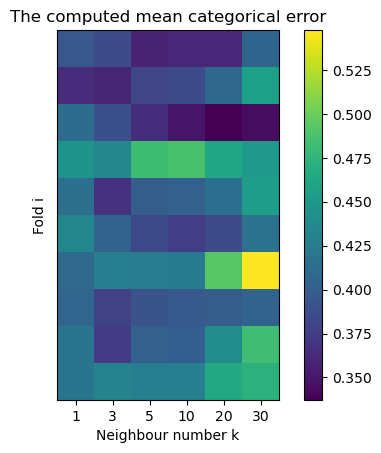

In [6]:
# Visualize the results
plt.title('The computed mean categorical error')

plt.imshow(errors)
plt.colorbar()

plt.yticks([])
plt.xticks(range(len(ks)), ks)

plt.xlabel('Neighbour number k')
plt.ylabel('Fold i')

In [7]:
# To find the best fold we compute the mean along the folds and find the minimum
min_index = np.argmin(errors.mean(axis = 0))
print(f'The best Neighbour-number is k = {ks[min_index]}')

The best Neighbour-number is k = 3


(c)

In [11]:
from sklearn.neighbors import KNeighborsClassifier

ks = (1, 3, 5, 10, 20, 30, 50)
n_folds = 10
errors = np.empty((len(dsets), n_folds, len(ks)))

for i, (features, labels) in enumerate(dsets):
    print(f'Dataset size {len(labels)}')
    for j, ((train_features, train_labels), (val_features, val_labels)) in enumerate(crossval_splits(features, labels, n_folds)):
        for l, k in enumerate(ks):
            # We need to ensure, that the number of neighbours is larger then the number of samples
            if len(train_labels) < k:
                errors[i,j,l] = 1 # Maximize the error if this is not the case
                continue

            classifier = KNeighborsClassifier(k) # define the classifier with k neighbours

            classifier.fit(train_features.T, train_labels) # train the classifier on the training fold

            pred_labels = classifier.predict(val_features.T)

            errors[i, j, l] = mean_err(pred_labels, val_labels)

Dataset size 70
Dataset size 280
Dataset size 1117


In [12]:
# TODO: make and interpret the plots as requested in the exercise
for i in range(3):
    min_index = np.argmin(errors[i,:,:].mean(axis = 0))
    print('The best Neighbour-number of the ' + ['small', 'medium', 'full'][i] + f' dataset is k = {ks[min_index]}')

The best Neighbour-number of the small dataset is k = 1
The best Neighbour-number of the medium dataset is k = 1
The best Neighbour-number of the full dataset is k = 10


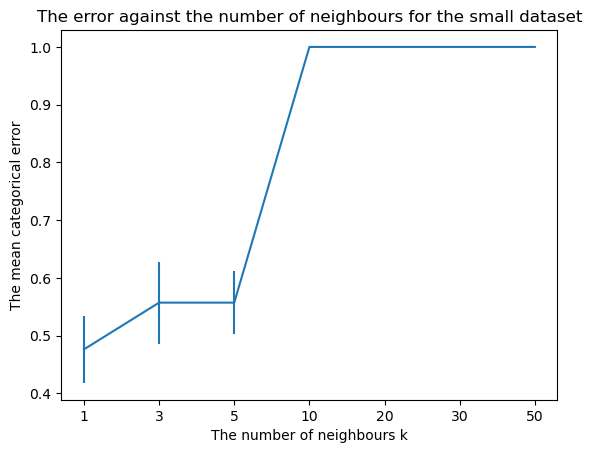

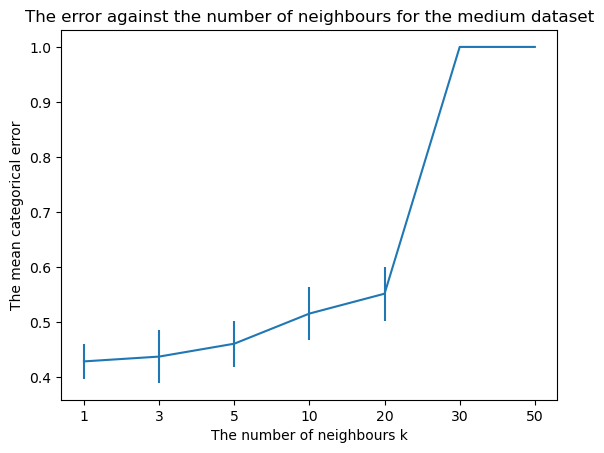

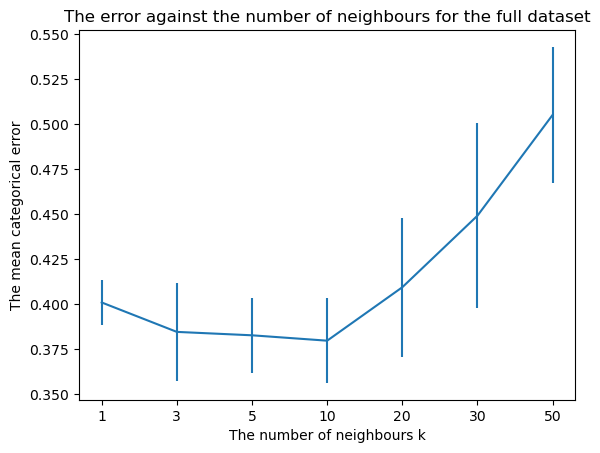

In [13]:
for i in range(3):
    plt.figure()
    plt.title('The error against the number of neighbours for the ' + ['small', 'medium', 'full'][i] + ' dataset')

    mean = errors[i,:,:].mean(axis = 0)
    std = errors[i,:,:].std(axis = 0)

    plt.errorbar(range(len(mean)), mean, std)

    plt.xticks(range(len(ks)), ks)

    plt.xlabel('The number of neighbours k')
    plt.ylabel('The mean categorical error')

We can see that for the full dataset we get a convex shape for the error with a minimum at k~10. <br>
The other datasets are also convex but with a minimum firmly at k=1. We can also see, that only small enough neighbournumbers are possible (as can be seen in the code).

The optimal value for k changes. I am not sure what an intuitive reason for that could be... <br>